# Lecture 4. Categories and Curves

Selected Examples

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import altair as alt

# to support rendering on github
alt.renderers.enable("mimetype")

import numpy as np
import pandas as pd
from scipy import stats

import statreth as sr

## Load data

In [3]:
# load data
howell1 = pd.read_csv("../data/Howell1.csv", delimiter=";")
howell1_18 = howell1[howell1.age >= 18]
howell1_18

,height,weight,age,male
0,151.765,47.825606,63.0,1
1,139.700,36.485807,63.0,0
2,136.525,31.864838,65.0,0
3,156.845,53.041914,41.0,1
4,145.415,41.276872,51.0,0
...,...,...,...,...
534,162.560,47.031821,27.0,0
537,142.875,34.246196,31.0,0
540,162.560,52.163080,31.0,1
541,156.210,54.062497,21.0,0


In [4]:
height = howell1_18.height.to_numpy()
weight = howell1_18.weight.to_numpy()
gender = howell1_18.male.to_numpy()

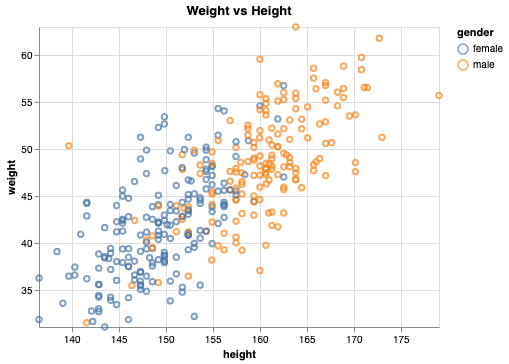

In [5]:
gender_str = [["female", "male"][g] for g in gender]
df = pd.DataFrame({"height": height, "weight": weight, "gender": gender_str})

data_chart = (
    alt.Chart(df, title="Weight vs Height")
    .mark_point()
    .encode(
        alt.X("height", scale=alt.Scale(domain=(height.min(), height.max()))),
        alt.Y("weight", scale=alt.Scale(domain=(weight.min(), weight.max()))),
        color="gender",
    )
)
data_chart

## Casual Effect of S on W?

In [6]:
# workaround to make stan run in jupyter
# https://pystan.readthedocs.io/en/latest/faq.html#how-can-i-use-pystan-with-jupyter-notebook-or-jupyterlab
import nest_asyncio

nest_asyncio.apply()
del nest_asyncio

In [7]:
import stan

In [9]:
code = """
data {
  int<lower=0> n;   // number of points
  vector[n] weight;
  int sex[n];
}
parameters {
  vector[2] alpha;
  real<lower=0> sigma;
}
model {
  // priors
  alpha ~ normal(60, 10);
  sigma ~ normal(10, 5);
  
  // likelihood
  weight ~ normal(alpha[sex], sigma);
}
"""

# set empty data, to sample from priors
data = {"n": len(weight), "weight": weight, "sex": gender + 1}

In [12]:
%%capture
posterior = stan.build(code, data=data, random_seed=42)

In [14]:
%%capture
fit = posterior.sample(num_chains=4, num_samples=1000)

In [15]:
fit_df = fit.to_frame()
fit_df[["alpha.1", "alpha.2", "sigma"]].describe().T

,count,mean,std,min,25%,50%,75%,max
parameters,,,,,,,,
alpha.1,4000.0,41.840071,0.417930,40.228721,41.549348,41.830126,42.131719,43.330708
alpha.2,4000.0,48.623614,0.444944,46.987122,48.318771,48.619903,48.932039,50.229060
sigma,4000.0,5.537812,0.209254,4.903558,5.394952,5.528134,5.670222,6.433816


In [16]:
alpha_df = fit_df[["alpha.1", "alpha.2", "sigma"]].copy()
alpha_df = alpha_df.rename(columns={"alpha.1": "female", "alpha.2": "male"})
alpha_df

parameters,female,male,sigma
draws,,,
0,42.359639,47.442577,5.338754
1,41.636454,48.252859,5.590474
2,42.378800,49.106079,5.599350
3,42.376708,48.492364,5.738965
4,41.200805,49.644543,5.737694
...,...,...,...
3995,42.311404,49.111812,5.323734
3996,42.170376,48.667708,5.484426
3997,41.232978,48.648270,5.414772


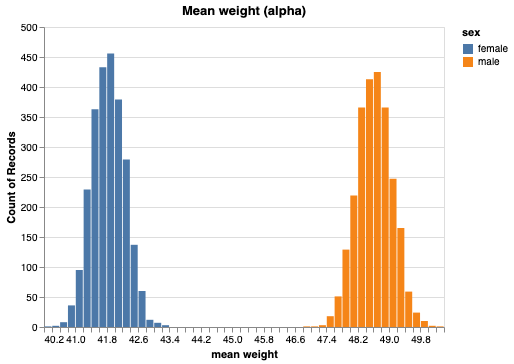

In [17]:
df = alpha_df[:2500][["female", "male"]].melt(var_name="sex", value_name="alpha")

hist = (
    alt.Chart(df, title="Mean weight (alpha)")
    .mark_bar(size=7)
    .encode(
        x=alt.X("alpha", title="mean weight", bin=alt.BinParams(maxbins=70)),
        y=alt.Y("count()", stack=None),
        color="sex",
    )
)

hist

In [18]:
alpha_df["contrast"] = alpha_df["male"] - alpha_df["female"]

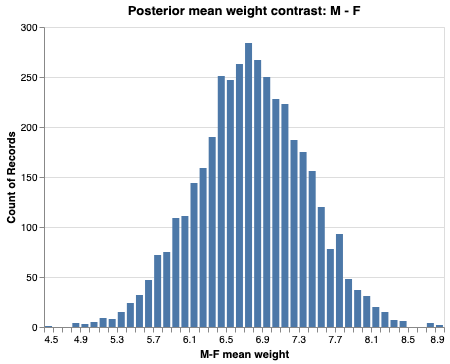

In [19]:
hist = (
    alt.Chart(alpha_df, title="Posterior mean weight contrast: M - F")
    .mark_bar(size=7)
    .encode(
        x=alt.X("contrast", title="M-F mean weight", bin=alt.BinParams(maxbins=50)),
        y="count()",
    )
)

hist

In [20]:
# sample posterior predictive
weight_female = np.random.normal(alpha_df["female"], alpha_df["sigma"])
weight_male = np.random.normal(alpha_df["male"], alpha_df["sigma"])

weight_contrast = weight_male - weight_female

In [21]:
print("M > F:", (weight_contrast > 0).mean())
print("M < F:", (weight_contrast < 0).mean())

M > F: 0.8065
M < F: 0.1935


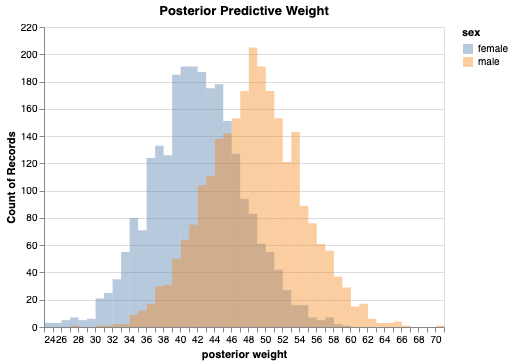

In [22]:
df = pd.DataFrame({"female": weight_female, "male": weight_male})
df = df[:2500].melt(var_name="sex", value_name="weight")

hist = (
    alt.Chart(df, title="Posterior Predictive Weight")
    .mark_bar(opacity=0.4, binSpacing=0)
    .encode(
        x=alt.X("weight", title="posterior weight", bin=alt.BinParams(maxbins=50)),
        y=alt.Y("count()", stack=None),
        color="sex",
    )
)

hist

## Direct causal effect of S on W?

In [23]:
height_mean = height.mean()
height_mean

154.5970926136364

In [24]:
code = """
data {
  int<lower=0> n; // number of points
  vector[n]    weight;
  vector[n]    height;
  real         height_mean;
  int sex[n];
}
parameters {
  vector[2] alpha; // intercept
  vector[2] beta;  // slope
  real<lower=0> sigma;
}
model {
  // priors
  alpha ~ normal(60, 10);
  beta ~ lognormal(0, 1);
  sigma ~ normal(10, 5);
  
  // likelihood
  for (i in 1:n) {
    real mu = alpha[sex[i]] + beta[sex[i]] * (height[i] - height_mean);
    weight[i] ~ normal(mu, sigma);
  }
}
"""

data = {
    "n": len(weight),
    "weight": weight,
    "sex": gender + 1,
    "height": height,
    "height_mean": height_mean,
}

In [25]:
%%capture
posterior = stan.build(code, data=data, random_seed=42)

In file included from /home/bayes/.local/lib/python3.10/site-packages/httpstan/include/stan/model/indexing.hpp:5,
                 from /home/bayes/.local/lib/python3.10/site-packages/httpstan/include/stan/model/model_header.hpp:17,
                 from /home/bayes/.cache/httpstan/4.8.2/models/ue2f6ksi/model_ue2f6ksi.cpp:2:
/home/bayes/.local/lib/python3.10/site-packages/httpstan/include/stan/model/indexing/assign_varmat.hpp: In function ‘void stan::model::assign(Mat1&&, const Mat2&, const char*, const stan::model::index_multi&, const stan::model::index_multi&)’:
/home/bayes/.local/lib/python3.10/site-packages/httpstan/include/stan/model/indexing/assign_varmat.hpp:401:9: warning: typedef ‘using pair_type = struct std::pair<int, std::vector<int, stan::math::arena_allocator<int> > >’ locally defined but not used [-Wunused-local-typedefs]
  401 |   using pair_type = std::pair<int, arena_vec>;
      |         ^~~~~~~~~
/home/bayes/.cache/httpstan/4.8.2/models/ue2f6ksi/model_ue2f6ksi.cpp: 

In [26]:
%%capture
fit = posterior.sample(num_chains=4, num_samples=1000)

In [27]:
fit_df = fit.to_frame()
fit_df[["alpha.1", "alpha.2", "beta.1", "beta.2", "sigma"]].describe().T

,count,mean,std,min,25%,50%,75%,max
parameters,,,,,,,,
alpha.1,4000.0,45.157222,0.447265,43.681410,44.860686,45.158974,45.467283,46.501372
alpha.2,4000.0,45.090245,0.461531,43.378497,44.775791,45.078239,45.405142,46.540331
beta.1,4000.0,0.655037,0.061540,0.443400,0.614819,0.655518,0.697623,0.887854
beta.2,4000.0,0.610408,0.055510,0.427609,0.572515,0.610096,0.647457,0.828204
sigma,4000.0,4.273258,0.163212,3.791868,4.158321,4.267525,4.378626,4.875288


In [29]:
height_grid = np.linspace(height.min(), height.max())

alpha_mean_female = fit_df["alpha.1"].mean()
alpha_mean_male = fit_df["alpha.2"].mean()

beta_mean_female = fit_df["beta.1"].mean()
beta_mean_male = fit_df["beta.2"].mean()

In [30]:
weight_mean_female = alpha_mean_female + beta_mean_female * (height_grid - height_mean)
weight_mean_male = alpha_mean_male + beta_mean_male * (height_grid - height_mean)

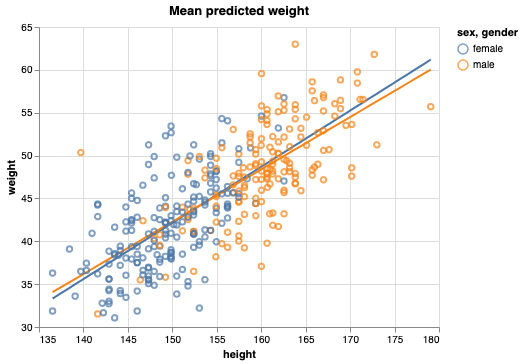

In [31]:
df = pd.DataFrame(
    {"height": height_grid, "female": weight_mean_female, "male": weight_mean_male}
)
df = df.melt("height", var_name="sex", value_name="weight")

lines_chart = (
    alt.Chart(df, title="Mean predicted weight")
    .mark_line(strokeWidth=2)
    .encode(x="height", y=alt.Y("weight", scale=alt.Scale(zero=False)), color="sex")
)

lines_chart + data_chart

In [32]:
rows = []
# probability interval masses
pis = [0.5, 0.6, 0.7, 0.8, 0.9, 0.99]
for h in height_grid:
    alpha_female = fit_df["alpha.1"]
    alpha_male = fit_df["alpha.2"]

    beta_female = fit_df["beta.1"]
    beta_male = fit_df["beta.2"]

    mu_female = alpha_female + beta_female * (h - height_mean)
    mu_male = alpha_male + beta_male * (h - height_mean)

    # F - M
    contrast = mu_female - mu_male
    row = {"height": h}

    # populare probability intervals
    for i, mass in enumerate(pis):
        low, high = sr.pi(contrast, mass)
        row[f"low_{i}"] = low
        row[f"high_{i}"] = high

        rows.append(row)

df = pd.DataFrame(rows)

In [33]:
from functools import reduce

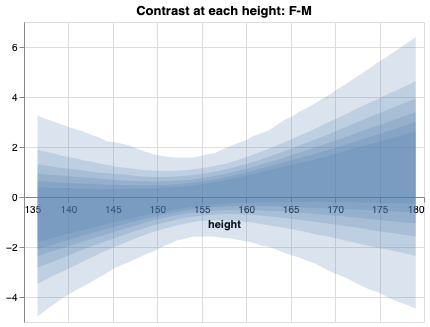

In [35]:
bands = []

for i, _ in enumerate(pis):
    band = (
        alt.Chart(df, title="Contrast at each height: F-M")
        .encode(x=alt.X("height", axis=alt.Axis(offset=-125)))
        .mark_area(opacity=0.2)
        .encode(alt.Y(f"high_{i}", axis=alt.Axis(title=None)), alt.Y2(f"low_{i}"))
    )
    bands.append(band)

reduce(lambda a, b: a + b, bands)

## Full Luxury Bayes
Estimate casual effects using one general model

In [46]:
code = """
data {
  int<lower=0> n;
  vector[n] weight;
  vector[n] height;
  int sex[n];
  real height_mean;
}
parameters {
  vector[2] alpha_w;
  vector[2] beta_w;
  vector[2] alpha_h;
  real<lower=0> sigma_w;
  real<lower=0> sigma_h;
}
model {
  // height
  alpha_h ~ normal(160, 10);
  sigma_h ~ normal(10, 5);

  vector[n] nu = alpha_h[sex];
  height ~ normal(nu, sigma_h);
  
  // weight
  alpha_w ~ normal(60, 10);
  beta_w ~ lognormal(0, 1);
  sigma_w ~ normal(10, 5);
  
  vector[n] mu;
  for (i in 1:n) {
    mu[i] = alpha_w[sex[i]] + beta_w[sex[i]] * (height[i] - height_mean);
  }
  
  weight ~ normal(mu, sigma_w);
}
"""

data = {
    "n": len(weight),
    "weight": weight,
    "sex": gender + 1,
    "height": height,
    "height_mean": height_mean,
}

In [48]:
%%capture
posterior = stan.build(code, data=data, random_seed=42)

In [49]:
%%capture
fit = posterior.sample(num_chains=4, num_samples=1000)

In [50]:
fit_df = fit.to_frame()

In [53]:
fit_df[
    [
        "alpha_w.1",
        "alpha_w.2",
        "beta_w.1",
        "beta_w.2",
        "alpha_h.1",
        "alpha_h.2",
        "sigma_w",
        "sigma_h",
    ]
].describe().T

,count,mean,std,min,25%,50%,75%,max
parameters,,,,,,,,
alpha_w.1,4000.0,45.169536,0.439233,43.580852,44.871732,45.166183,45.467414,46.941972
alpha_w.2,4000.0,45.102213,0.456682,43.448959,44.799866,45.098157,45.404350,46.682905
beta_w.1,4000.0,0.657411,0.061935,0.457045,0.615772,0.657116,0.700056,0.875400
beta_w.2,4000.0,0.608200,0.055322,0.430951,0.571028,0.608705,0.644999,0.810715
alpha_h.1,4000.0,149.529720,0.403305,148.158224,149.255946,149.526590,149.800371,151.063817
alpha_h.2,4000.0,160.354850,0.437389,158.877340,160.067791,160.354147,160.642962,161.854235
sigma_w,4000.0,4.268993,0.160941,3.711423,4.159470,4.264802,4.374245,4.916878
sigma_h,4000.0,5.562395,0.201075,4.906780,5.425249,5.555931,5.696643,6.407880


### Simulate synthetic people

In [64]:
n = int(1e4)

In [80]:
# females
alpha_h_female = fit_df['alpha_h.1']
sigma_h = fit_df['sigma_h']
syn_height_female = np.random.normal(alpha_h_female, sigma_h)

alpha_w_female = fit_df['alpha_w.1']
beta_w_female = fit_df['beta_w.1']
sigma_w = fit_df['sigma_w']
mu_female = alpha_w_female + beta_w_female * (syn_height_female - height_mean)
syn_weight_female = np.random.normal(mu_female, sigma_w)

In [81]:
# males
alpha_h_male = fit_df['alpha_h.2']
sigma_h = fit_df['sigma_h']
syn_height_male = np.random.normal(alpha_h_male, sigma_h)

alpha_w_male = fit_df['alpha_w.2']
beta_w_male = fit_df['beta_w.2']
sigma_w = fit_df['sigma_w']
mu_male = alpha_w_male + beta_w_male * (syn_height_male - height_mean)
syn_weight_male = np.random.normal(mu_male, sigma_w)

### Total casual effect of S on W

In [82]:
weight_do_sex = syn_weight_male - syn_weight_female

In [83]:
print("M > F:", (weight_do_sex > 0).mean())
print("M < F:", (weight_do_sex < 0).mean())

M > F: 0.817
M < F: 0.183


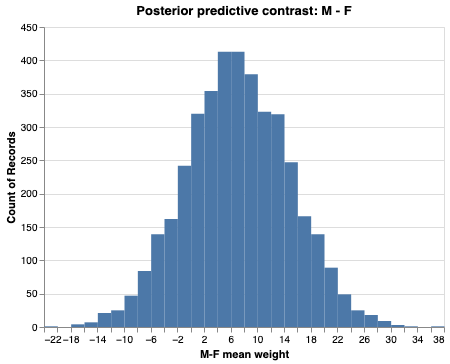

In [84]:
df = pd.DataFrame({"weight_do_sex": weight_do_sex})

hist = (
    alt.Chart(df, title="Posterior predictive contrast: M - F")
    .mark_bar(binSpacing=0)
    .encode(
        x=alt.X("weight_do_sex", title="M-F mean weight", bin=alt.BinParams(maxbins=50)),
        y="count()",
    )
)

hist

### Direct casual effect of S on W

In [85]:
rows = []
# probability interval masses
pis = [0.5, 0.6, 0.7, 0.8, 0.9, 0.99]
for h in height_grid:
    mu_female = alpha_w_female + beta_w_female * (h - height_mean)
    mu_male = alpha_w_male + beta_w_male * (h - height_mean)

    # F - M
    contrast = mu_female - mu_male
    row = {"height": h}

    # populare probability intervals
    for i, mass in enumerate(pis):
        low, high = sr.pi(contrast, mass)
        row[f"low_{i}"] = low
        row[f"high_{i}"] = high

        rows.append(row)

df = pd.DataFrame(rows)

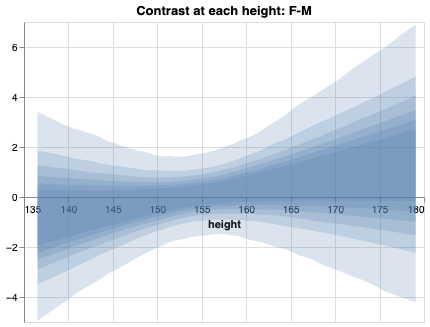

In [87]:
bands = []

for i, _ in enumerate(pis):
    band = (
        alt.Chart(df, title="Contrast at each height: F-M")
        .encode(x=alt.X("height", axis=alt.Axis(offset=-125)))
        .mark_area(opacity=0.2)
        .encode(alt.Y(f"high_{i}", axis=alt.Axis(title=None)), alt.Y2(f"low_{i}"))
    )
    bands.append(band)

reduce(lambda a, b: a + b, bands)